In [1]:

import pandas as pd

from sklearn.externals import joblib
# Added version check for recent scikit-learn 0.18 checksok ca
from distutils.version import LooseVersion as Version
import numpy as np
from dateutil.parser import parse
import datetime as dt
from numba import jit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_fscore_support 
from tqdm import tqdm, tqdm_notebook

from collections import OrderedDict
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import random, os, csv      # random is the rng, os is the operating system, and csv handles
                            # CSV files
import matplotlib.pyplot as plt  # This is the plotter
import time                 # This allows for lots of neat tricks.
import powerlaw
import mpmath
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns

plt.style.use('seaborn-talk')
plt.style.use('bmh')

#plt.rcParams['font.family'] = 'DejaVu Sans Mono'
#plt.rcParams['font.size'] = 9.5
plt.rcParams['font.weight'] = 'medium'
#plt.rcParams['figure.figsize'] = 10,7
blue, green, red, purple, gold, teal = sns.color_palette('colorblind', 6)



In [2]:
def returns(s):
    #compute log returns
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))

def tick_bars(df, price_column, m):
    '''
    compute tick bars
    # args
        df: pd.DataFrame()
        column: name for price data
        m: int(), threshold value for ticks
    # returns
        idx: list of indices
    '''
    t = df[price_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx
def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx]
#========================================================
def volume_bars(df, volume_column, m):
    '''
    compute volume bars
    # args
        df: pd.DataFrame()
        column: name for volume data
        m: int(), threshold value for volume
    # returns
        idx: list of indices
    '''
    t = df[volume_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx]
#========================================================
def dollar_bars(df, dv_column, m):
    '''
    compute dollar bars
    # args
        df: pd.DataFrame()
        column: name for dollar volume data
        m: int(), threshold value for dollars
    # returns
        idx: list of indices
    '''
    t = df[dv_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += x
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
    return idx

def dollar_bar_df(df, dv_column, m):
    idx = dollar_bars(df, dv_column, m)
    return df.iloc[idx]
#========================================================
dataparser = lambda x: pd.datetime.strptime(x, '%M:%S.%f').time
#========================================================
@jit(nopython=True)
def mad_outlier(y, thresh=3.):
    '''
    compute outliers based on mad
    # args
        y: assumed to be array with shape (N,1)
        thresh: float()
    # returns
        array index of outliers
    '''
    median = np.median(y)
    diff = np.sum((y - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


In [3]:
futures_data_folder= '/home/ak/Documents/Data/FuturesData/'
csv_files=[s for s in os.listdir(futures_data_folder) if s.endswith('.csv')]

In [4]:
csv_idx=1
csv_loc = "".join((futures_data_folder,csv_files[csv_idx]))
raw_data=pd.read_csv(csv_loc)
raw_data.columns.values
raw_data=raw_data.rename(columns={'Unnamed: 0':'TimeStamp'})

In [5]:

raw_data['MicroPrice']=(raw_data['bestAskPrice']*raw_data['bestAskSize']+raw_data['bestBidPrice']*raw_data['bestBidSize'])/(raw_data['bestAskSize']+raw_data['bestBidSize'])
raw_data.head()


,TimeStamp,bestAskPrice,bestBidSize,bestAskSize,bestBidPrice,MicroPrice
0,00:00.0,98.07,1689,2960,98.065,98.068183
1,00:02.8,98.07,1689,2964,98.065,98.068185
2,00:05.1,98.07,1689,2973,98.065,98.068189
3,00:25.8,98.07,1689,2953,98.065,98.068181
4,00:48.4,98.07,1688,2953,98.065,98.068181


In [6]:
# from StringIO import StringIO
# in_ = StringIO()
# in_.write(raw_data['TimeStamp'])
# in_.seek(0)


In [7]:
raw_data['TimeStamp']=pd.to_datetime(raw_data['TimeStamp'], format='%M:%S.%f' )
raw_data['TimeStamp'].dt.time
raw_data['TimeStamp']=pd.to_datetime(raw_data['TimeStamp'])
raw_data['logRetMicroPrice']=returns(raw_data.MicroPrice)

In [8]:
raw_data['milliSeconds']=[int(((x.hour*60 + x.minute)*60 + x.second)*1000) for x in raw_data['TimeStamp']]
raw_data['Duration']= raw_data['milliSeconds'].diff(1)
raw_data=raw_data.dropna()

In [9]:
# for x in range(raw_data.shape[0]):
#     t= raw_data['TimeStamp'][x]
#     print (t.hour*60 + t.minute)*60 + t.second 

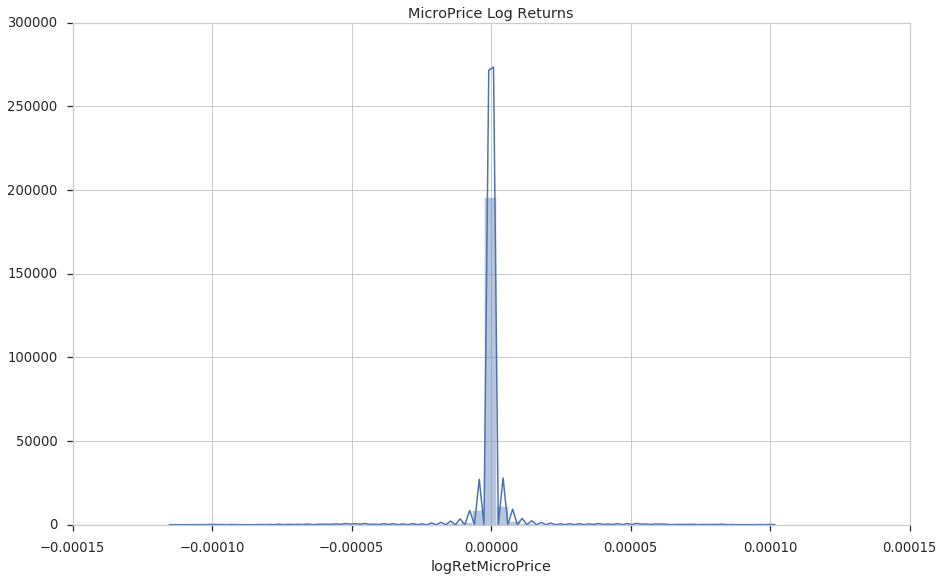

In [10]:
plt.figure(figsize=(15,9))
sns.light_palette("navy", reverse=True)
#sns.set_palette("husl")
sns.color_palette("PuBuGn_d")
sns.set_context("talk")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
ax=sns.distplot(raw_data.logRetMicroPrice)
plt.title('MicroPrice Log Returns')
ax.tick_params(right=False, top=False)

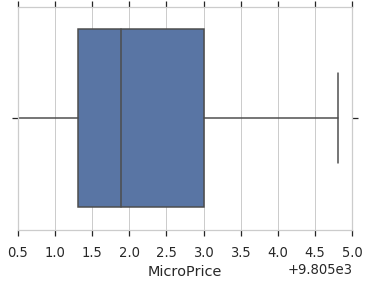

In [11]:
mad = mad_outlier(raw_data.MicroPrice.values.reshape(-1,1))
sns.boxplot(raw_data.loc[~mad].MicroPrice*100)

In [12]:
df= raw_data
s1=df.bestAskSize
s2=df.bestBidSize
df['v']=pd.concat([s1, s2], axis=1).min(axis=1)
# np.min(df.bestAskSize, df.bestBidPrice)
df['dv']= df.v*df.MicroPrice

In [47]:
n_ticks = df.shape[0]
volume_ratio = (df.v.sum()/n_ticks).round()
dollar_ratio = (df.dv.sum()/n_ticks).round()
print('num ticks:', n_ticks)
print('volume ratio:', volume_ratio)
print('dollar ratio:', dollar_ratio)

('num ticks:', 18329)
('volume ratio:', 572)
('dollar ratio:', 56119.0)


In [54]:
tick_M = 20 # arbitrary
print('tick threshold:', tick_M)
tidx = tick_bars(df, 'MicroPrice', tick_M)
tidx[:10]



100%|██████████| 18329/18329 [00:00<00:00, 1826847.54it/s]

('tick threshold:', 20)


[19, 39, 59, 79, 99, 119, 139, 159, 179, 199]

In [55]:


tick_df = tick_bar_df(df, 'MicroPrice', tick_M)
tick_df.shape



100%|██████████| 18329/18329 [00:00<00:00, 977598.88it/s]


(916, 11)

In [56]:
def select_sample_data(ref, sub, price_col, idx_1,idx_2):
    '''
    select a sample of data based on date, assumes datetimeindex
    
    # args
        ref: pd.DataFrame containing all ticks
        sub: subordinated pd.DataFrame of prices
        price_col: str(), price column
        date: str(), date to select
    # returns
        xdf: ref pd.Series
        xtdf: subordinated pd.Series
    '''
    xdf = df[price_col].iloc[idx_1:idx_2]
    xtdf = sub[price_col].iloc[idx_1:idx_2]
    return xdf, xtdf

## try different dates to see how the quantity of tick bars changes
idx_1=0
idx_2=1000
xdf, xtdf = select_sample_data(df, tick_df, 'MicroPrice', idx_1,idx_2)

xdf.shape, xtdf.shape

((1000,), (916,))

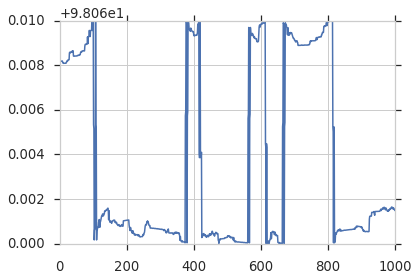

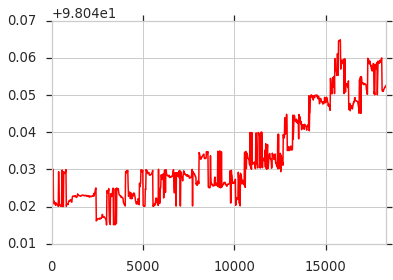

ValueError: max() arg is an empty sequence

In [76]:
bar_type='tick bar'
# f,axes=plt.subplots(1,sharex=True, figsize=(10,7))
ref=xdf
sub=xtdf
ref.plot(label='price')
plt.show()
sub.plot(color='red',label=bar_type)
plt.show()


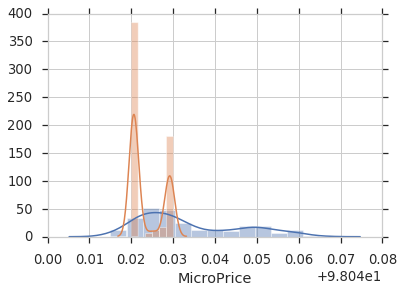

In [78]:

sns.distplot(sub)
sns.distplot(ref)

1       98.068185
2       98.068189
3       98.068181
4       98.068181
5       98.068181
6       98.068177
7       98.068184
8       98.068184
9       98.068111
10      98.068114
11      98.068084
12      98.068081
13      98.068085
14      98.068084
15      98.068085
16      98.068084
17      98.068093
18      98.068084
19      98.068093
20      98.068111
21      98.068183
22      98.068179
23      98.068187
24      98.068191
25      98.068240
26      98.068245
27      98.068240
28      98.068245
29      98.068549
30      98.068579
          ...    
971     98.061547
972     98.061517
973     98.061606
974     98.061577
975     98.061547
976     98.061517
977     98.061486
978     98.061455
979     98.061486
980     98.061455
981     98.061486
982     98.061517
983     98.061486
984     98.061517
985     98.061547
986     98.061577
987     98.061547
988     98.061577
989     98.061606
990     98.061635
991     98.061606
992     98.061635
993     98.061606
994     98.061577
995     98

In [ ]:
#[parse(raw_data['TimeStamp'][x] for x in range(raw_data.shape[0]))]


In [ ]:
durations=[]
length= raw_data.shape[0]-1
for idx in range(0,100):
    x=(parse(raw_data['TimeStamp'][idx])).time()
    y=datetime.timedelta(hours= x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond)
    durations.append(y.total_seconds())

In [ ]:
# pd.to_timedelta(raw_data['TimeStamp'])
# # [parse(x) for x in raw_data['TimeStamp'][x]]
# # # x=times[1]
# # # # y = datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond)

In [ ]:
import datetime
# datetime.datetime.strptime(raw_data['TimeStamp'][1])
parse(raw_data['TimeStamp'][26000])

In [ ]:
y=datetime.timedelta(hours= x.hour, minutes=x.minute, seconds=x.second, microseconds=x.microsecond)

In [ ]:
raw_data['microPrice']=(raw_data['bestAskPrice']*raw_data['bestAskSize']+ raw_data['bestBidPrice']*raw_data['bestBidSize'])/(raw_data['bestAskSize']+raw_data['bestBidSize'])

In [ ]:
raw_data['returns'] =raw_data['microPrice'].pct_change()*100

In [ ]:
df=raw_data.dropna()

In [ ]:
def autocorr(x):
    n = x.size
    norm = (x - np.mean(x))
    result = np.correlate(norm, norm, mode='same')
    acorr = result[n//2 + 1:] / (x.var() * np.arange(n-1, n//2, -1))
    lag = np.abs(acorr).argmax() + 1
    r = acorr[lag-1]        
    if np.abs(r) > 0.5:
        print('Appears to be autocorrelated with r = {}, lag = {}'. format(r, lag))
    else: 
        print('Appears to be not autocorrelated')
    return r, lag


In [ ]:
autocorr(df['microPrice'])

In [ ]:
df['Sqrd_returns']=(df['returns']**2)*100

In [ ]:
df['Sqrd_returns'].plot()

In [ ]:
import statsmodels as sts
# Importing lag_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot


In [ ]:
series = df['microPrice']
# Plotting the lagged values of the series
lag_plot(series)
plt.show()
autocorrelation_plot(series)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(series)
plt.show()
# plot_pacf(series)
# plt.show()

In [ ]:
sns.lmplot(x='microPrice', y='Sqrd_returns', data=df)
#do calculation using high and low

In [ ]:
import powerlaw
import mpmath

In [ ]:
fit_returns_discrete = powerlaw.Fit(df['returns'], discrete=False) 
# fitwolf = powerlaw.Fit(Wolfdata, discrete=True)

In [ ]:
fit_returns_discrete

In [ ]:
print("For the Generated Data")
print("Max Likelihood Estimate of Alpha: %5.3f" % (fitgen.power_law.alpha)) 
cutoffString_gen = '{:,.2f}'.format(fitgen.power_law.xmin)  # I'm just formatting the output
print("Cutoff value, xmin:  "+cutoffString_gen)